# Exploratory Data Analysis (EDA)

Now that we have performed the data cleansing, we can start exploring the data to
understand the relationships between the features and the target variable. We will start
by loading the data and checking the first few rows.

## Load the data and create variables

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor

from churn.config import INTERIM_DATA_FILE, PROCESSED_DATA_FILE
from churn.plots import (
    customized_pairplot,
    plot_categories_percentages,
    plot_category_distribution_by_target,
    plot_target_distribution_by_category
)
from churn.utils import StatisticalAnalysisBinary, best_grid_shape

In [2]:
# fastparquet is better to handle the category type
df = pd.read_parquet(INTERIM_DATA_FILE, engine="fastparquet")

df.head()

,customerID,Contract,Dependents,DeviceProtection,Gender,InternetService,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,...,PaymentMethod,PhoneService,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,MonthlyCharges,TotalCharges,Tenure,Churn
0,7590-VHVEG,Month-to-month,No,No,Female,DSL,No phone service,Yes,No,Yes,...,Electronic check,No,No,No,No,No,29.85,29.85,1,No
1,5575-GNVDE,One year,No,Yes,Male,DSL,No,No,Yes,No,...,Mailed check,Yes,No,No,No,No,56.95,1889.50,34,No
2,3668-QPYBK,Month-to-month,No,No,Male,DSL,No,Yes,Yes,Yes,...,Mailed check,Yes,No,No,No,No,53.85,108.15,2,Yes
3,7795-CFOCW,One year,No,Yes,Male,DSL,No phone service,No,Yes,No,...,Bank transfer,No,No,No,No,Yes,42.30,1840.75,45,No
4,9237-HQITU,Month-to-month,No,No,Female,Fiber optic,No,No,No,Yes,...,Electronic check,Yes,No,No,No,No,70.70,151.65,2,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Contract          7043 non-null   category
 2   Dependents        7043 non-null   category
 3   DeviceProtection  7043 non-null   category
 4   Gender            7043 non-null   category
 5   InternetService   7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   OnlineBackup      7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   PaperlessBilling  7043 non-null   category
 10  Partner           7043 non-null   category
 11  PaymentMethod     7043 non-null   category
 12  PhoneService      7043 non-null   category
 13  SeniorCitizen     7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  StreamingTV       7043 non-null   category
 16  TechSupport       7043 n

Let's separate the features and the target variable and create some variables to help us
with the analysis.

In [4]:
numeric_features = sorted(df.select_dtypes(include="number").columns.to_list())

target = "Churn"

id_column = "customerID"

categorical_features = sorted(
    df.select_dtypes(include="category").columns.drop([target]).to_list()
)

In [5]:
display(numeric_features)
display(categorical_features)

['MonthlyCharges', 'Tenure', 'TotalCharges']

['Contract',
 'Dependents',
 'DeviceProtection',
 'Gender',
 'InternetService',
 'MultipleLines',
 'OnlineBackup',
 'OnlineSecurity',
 'PaperlessBilling',
 'Partner',
 'PaymentMethod',
 'PhoneService',
 'SeniorCitizen',
 'StreamingMovies',
 'StreamingTV',
 'TechSupport']

## Numeric features

We have already looked at the numeric features in the previous notebook when we were
searching for outliers. We saw, using boxplots, that outliers are not a big issue in this
dataset and that the classes have different distributions for some features. We will
confirm this by plotting the histograms and KDE plots for the numeric features.
Besides confirming the differences in the distributions, we will also check the
skewness of the features. This will help us decide if we need to transform the features
before training the models.

In [6]:
with pd.option_context(
    "display.float_format", "{:.2f}".format, "display.max_columns", None
):
    display(df.describe())

,MonthlyCharges,TotalCharges,Tenure
count,7043.00,7043.00,7043.00
mean,64.76,2279.80,32.37
std,30.09,2266.73,24.56
min,18.25,18.80,0.00
25%,35.50,398.55,9.00
50%,70.35,1394.55,29.00
75%,89.85,3786.60,55.00
max,118.75,8684.80,72.00


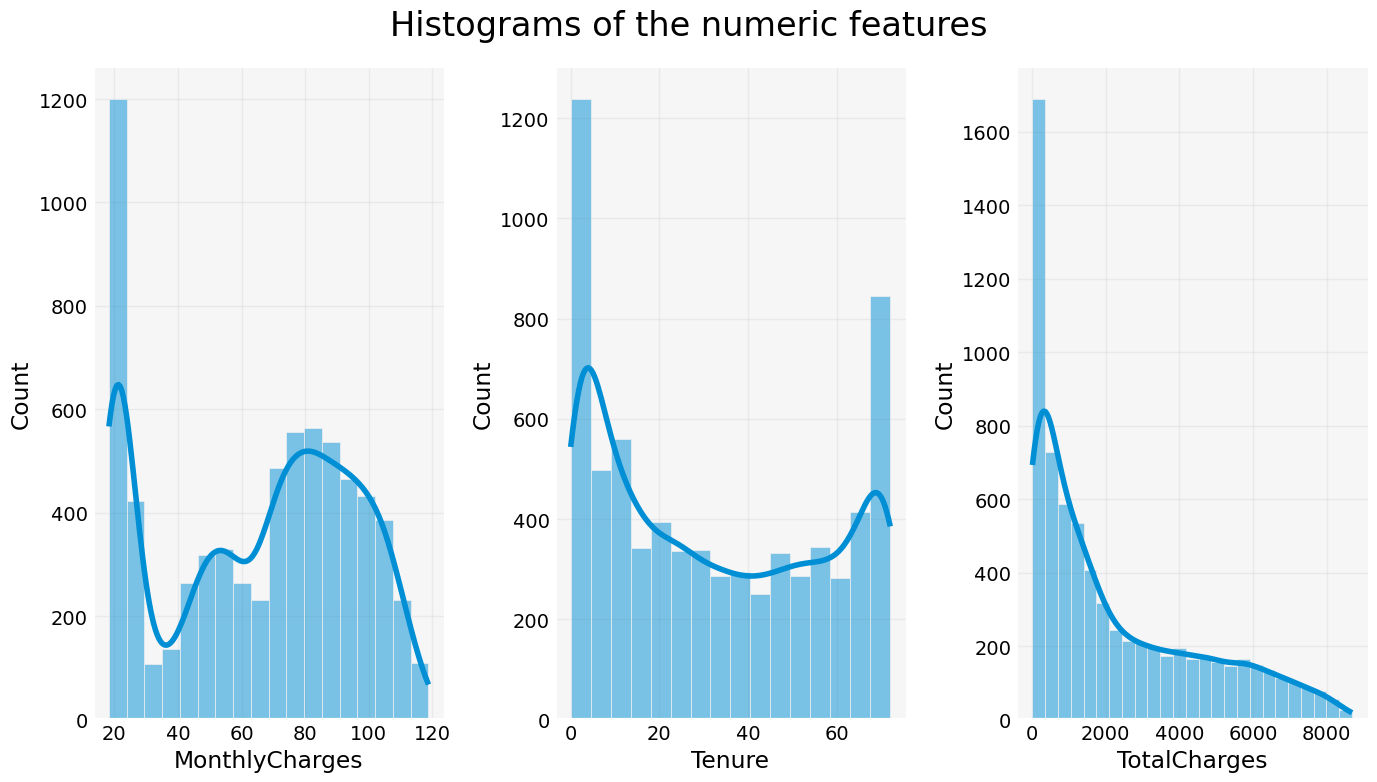

In [7]:
fig, axs = plt.subplots(*best_grid_shape(len(numeric_features)), tight_layout=True)

for ax, column in zip(axs.ravel(), numeric_features):
    h = sns.histplot(
        data=df,
        x=column,
        ax=ax,
        kde=True,
    )

fig.suptitle("Histograms of the numeric features")

plt.show()

The tenure distribution has an interesting shape. Most customers have been with the
company for just a few months, but also many have been for about 72 months (maximum
value for tenure). This is probably related to different contracts, something that we
will check soon. Likely some marketing campaign was run recently to capture new
customers due to the high number of customers with few months.

We can see that most customers pay low monthly charges, but there is a great fraction
with medium values. Since most customers have been with the company for just a few
months, the total charges plot shows most customers with low values.


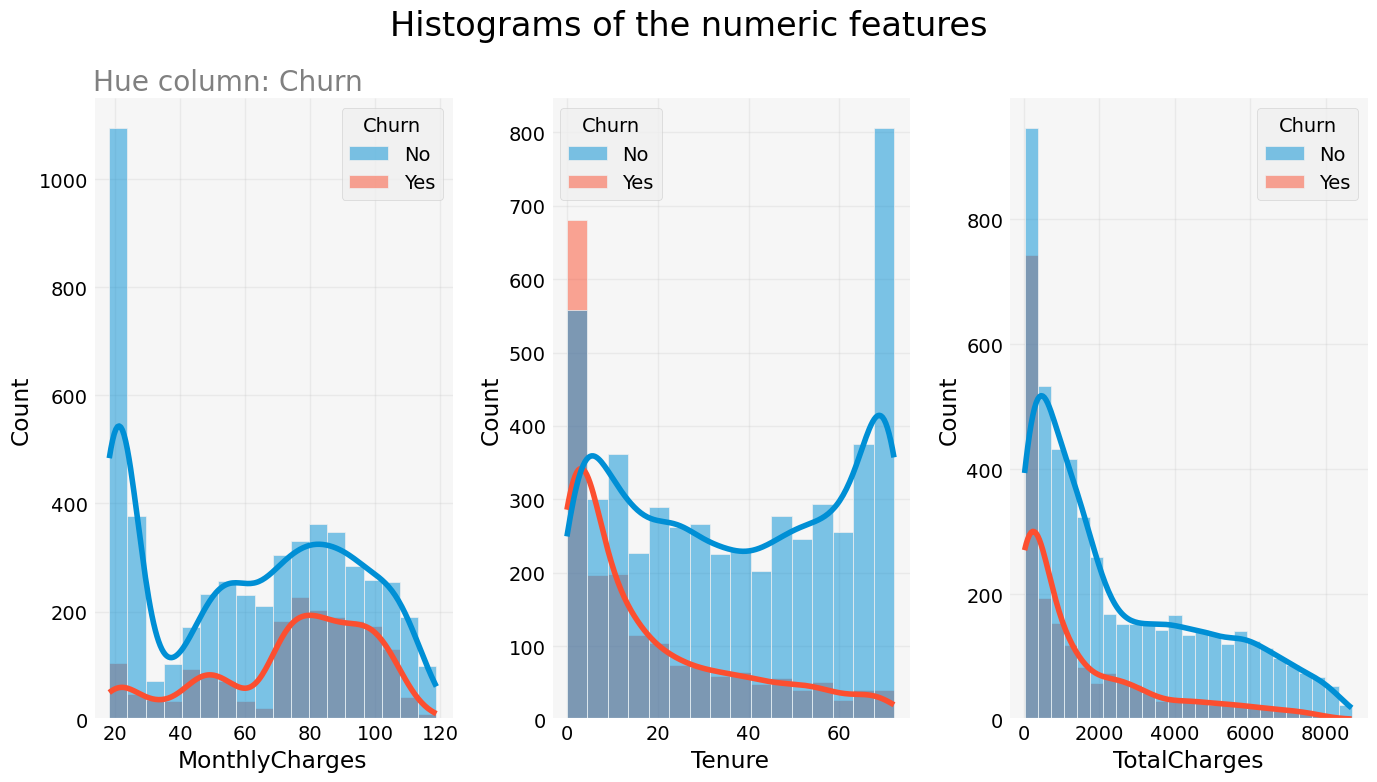

In [8]:
fig, axs = plt.subplots(*best_grid_shape(len(numeric_features)), tight_layout=True)

for ax, column in zip(axs.ravel(), numeric_features):
    h = sns.histplot(
        data=df,
        x=column,
        ax=ax,
        kde=True,
        hue=target,
    )

axs[0].set_title(f"Hue column: {target}")
fig.suptitle("Histograms of the numeric features")

plt.show()

The above plot shows that short tenure (recent) customers have higher churn rates. Moreover, the higher the monthly charge, the higher the churn rate.

Let's check if these features distributions have some kind of relation with the kind of contract:

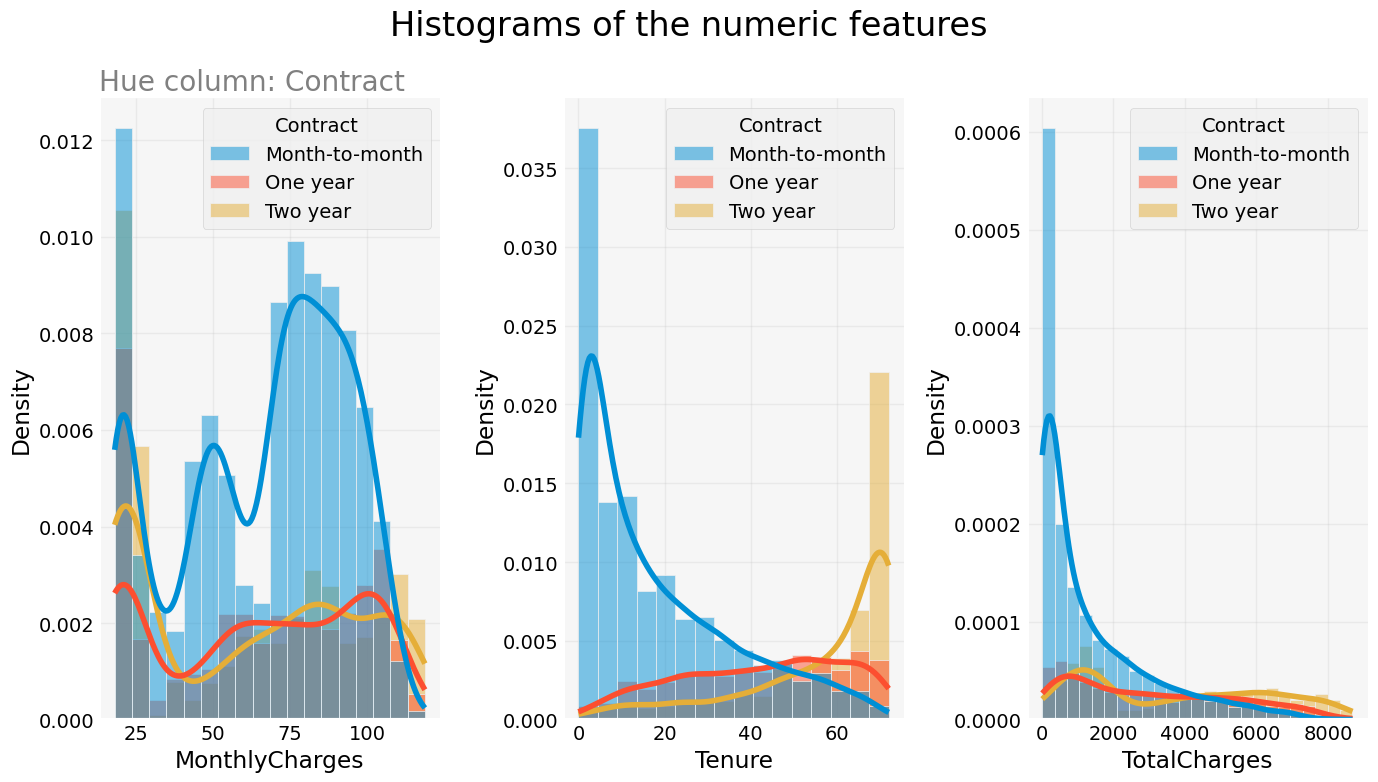

In [9]:
fig, axs = plt.subplots(*best_grid_shape(len(numeric_features)), tight_layout=True)

for ax, column in zip(axs.ravel(), numeric_features):
    h = sns.histplot(
        data=df,
        x=column,
        ax=ax,
        kde=True,
        hue="Contract",
        stat="density",
    )

axs[0].set_title(f"Hue column: Contract")
fig.suptitle("Histograms of the numeric features")

plt.show()

As can be seen, most of the monthly contracts last for a few months, while the 2-year
contracts tend to last for years, with a great increase towards the greater values of
tenure in this dataset. This implies that customers with a great commitment at the
beginning, like a 2-year contract, tend to stay with the company for a longer period of
time. Long-term contracts usually have contractual fines. Therefore, customers have to
wait until the end of the contract to churn. It is not clear if it is the case. A
time-series data would be better to study this.

We can further check the relation between the kind of contract and the monthly and total
charges with violin plots:

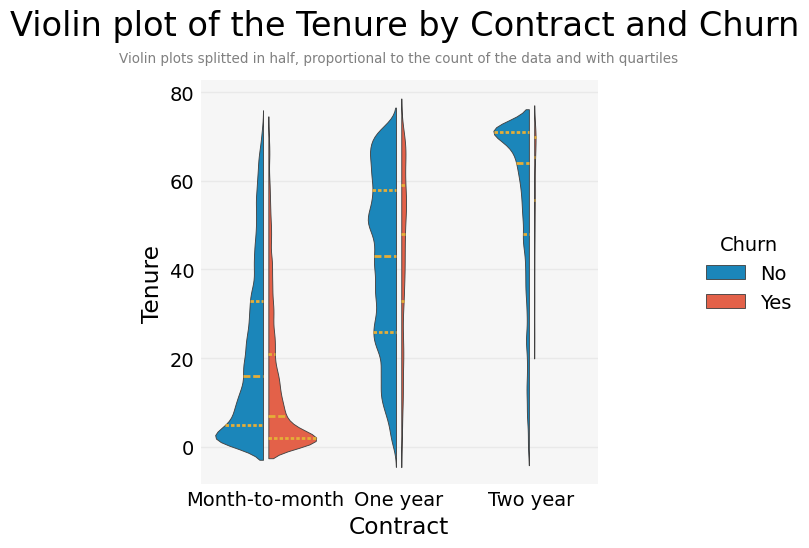

In [10]:
g = sns.catplot(
    data=df,
    x="Contract",
    y="Tenure",
    hue=target,
    kind="violin",
    split=True,
    gap=0.1,
    inner="quartile",
    density_norm="count",
    bw_adjust=0.5,
    inner_kws={"color": "C2", "linewidth": 2},
)

g.ax.set_title(
    "Violin plots splitted in half, proportional to the count of the data and with quartiles",
    y=1.025,
    fontsize="x-small",
    loc="center",
)

g.figure.suptitle("Violin plot of the Tenure by Contract and Churn", y=1.10)


plt.show()

Violin plots are a combination of boxplots and KDE plots. They show the distribution of
the data and the probability density of the different values. We can see that the
most contracts are month-to-month and that customers with this kind of contract tend to
churn more (larger density of churned customers). Moreover, the churned customers tend to
churn earlier, as we saw in the tenure distribution plot.

We can check the relation between the kind of contract and the monthly charges:

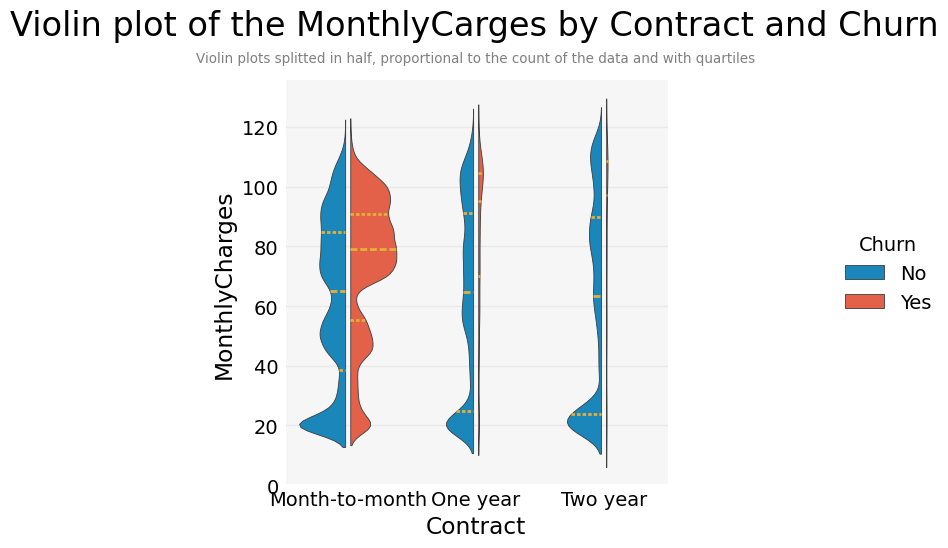

In [11]:
g = sns.catplot(
    data=df,
    x="Contract",
    y="MonthlyCharges",
    hue=target,
    kind="violin",
    split=True,
    gap=0.1,
    inner="quartile",
    density_norm="count",
    bw_adjust=0.5,
    inner_kws={"color": "C2", "linewidth": 2},
)

g.ax.set_title(
    "Violin plots splitted in half, proportional to the count of the data and with quartiles",
    y=1.025,
    fontsize="x-small",
    loc="center",
)

g.figure.suptitle("Violin plot of the MonthlyCharges by Contract and Churn", y=1.10)


plt.show()

Again, it is clear that the month-to-month contracts have higher churn customers. The
shape of the distribution for the churned customers has a broad peak towards the higher
values of monthly charges. This implies that customers with higher monthly charges tend
to churn more. This is probably because they are not satisfied with the service or they
found a better deal.

We can now check how the type of internet service affects the churn rate:

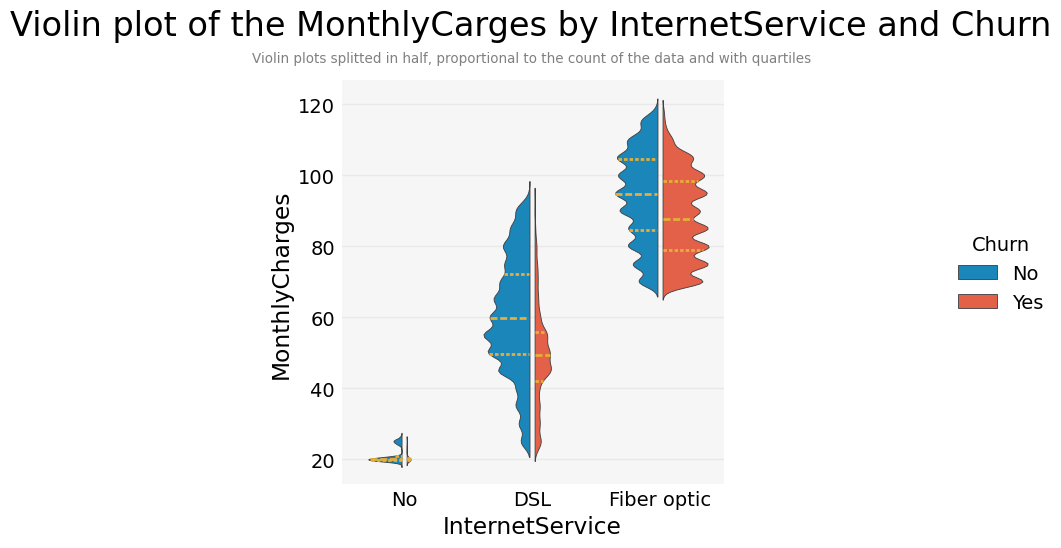

In [12]:
g = sns.catplot(
    data=df,
    x="InternetService",
    y="MonthlyCharges",
    hue=target,
    kind="violin",
    split=True,
    gap=0.1,
    inner="quartile",
    density_norm="count",
    bw_adjust=0.5,
    inner_kws={"color": "C2", "linewidth": 2},
)

g.ax.set_title(
    "Violin plots splitted in half, proportional to the count of the data and with quartiles",
    y=1.025,
    fontsize="x-small",
    loc="center",
)

g.figure.suptitle("Violin plot of the MonthlyCharges by InternetService and Churn", y=1.10)


plt.show()

As expected, fiber optic has a higher monthly charge than DSL. This is probably because
fiber optic is faster and more reliable. However, the churn rate for fiber optic is also
higher. This is most likely because customers are not satisfied with the service, even
though it is faster. We don't know when the data was collected\*, but some customers
perhaps didn't think that the additional speed was worth the additional cost.

\* Actually, the data is synthetic, as stated in the dataset description. However,
it is still generated to resemble a real-world scenario. Since the dataset it is
available for some time, we can assume that it is from a time when fiber optic was a new
technology and high speed was not as common (and needed) as it is today.

## Pairplots

Pairplots are a great way to visualize the relationships between the features. It shows
the scatter plots of each pair of features and the diagonal shows the distribution of
each feature. We can use the hue parameter to color the points according to a
categorical feature or the target variable.

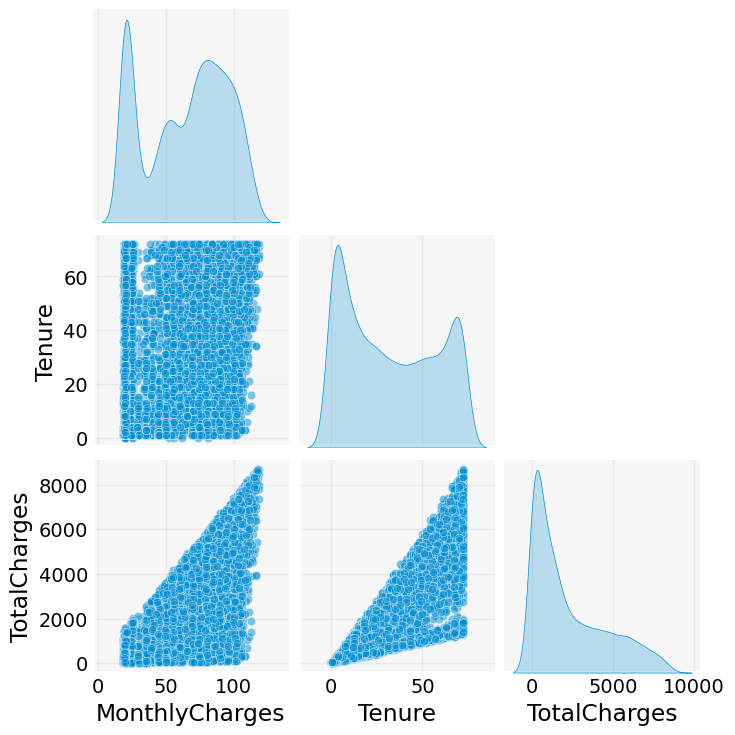

In [13]:
customized_pairplot(df, numeric_features)

We have already seen how the numeric features are related to the target variable. But
we can now check using pairplots:

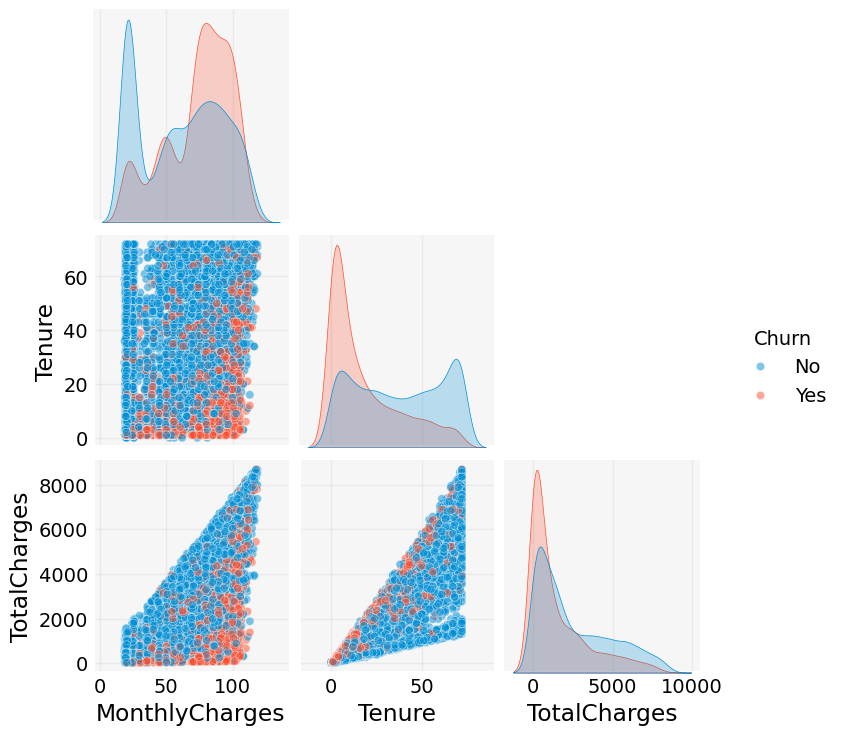

In [14]:
customized_pairplot(df, numeric_features, hue_column=target)

We could plot many other pairplots, using each categorical feature as the hue. However,
this would generate too many plots and the study would be challenging to follow. 
Besides, there are better ways to check the relation between categorical features and the
target variable (categorical plots and statistical tests). We will do this in later in
this notebook.  Let's check only one more pairplot, using the senior citizen column as
the hue:


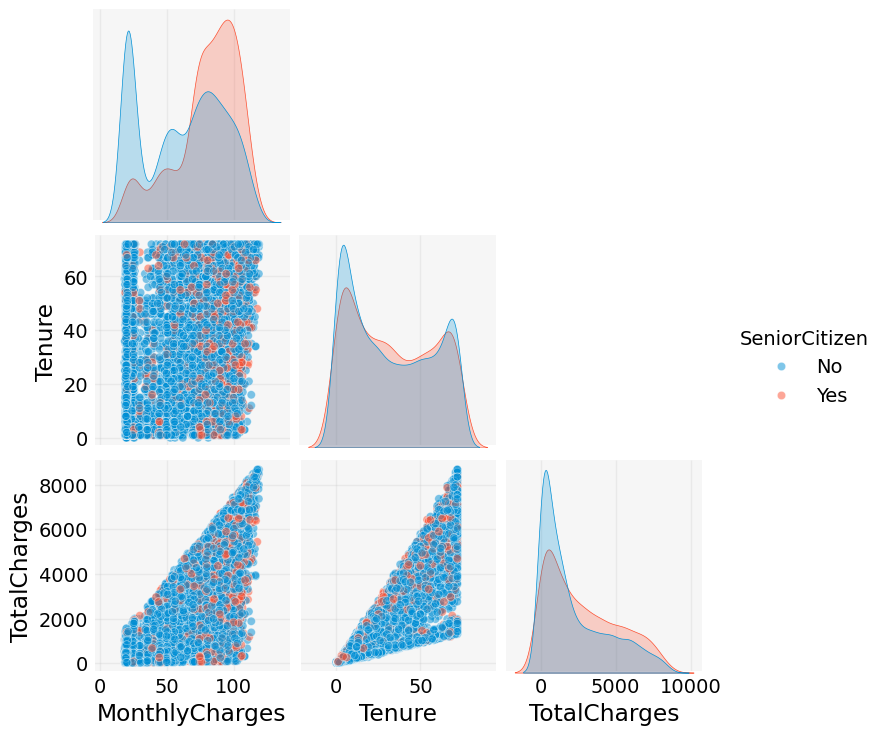

In [15]:
customized_pairplot(df, numeric_features, hue_column="SeniorCitizen")

We see that senior citizens tend to have higher monthly charges.

## Categorical features

Let's find out the proportion of each category in the categorical features:

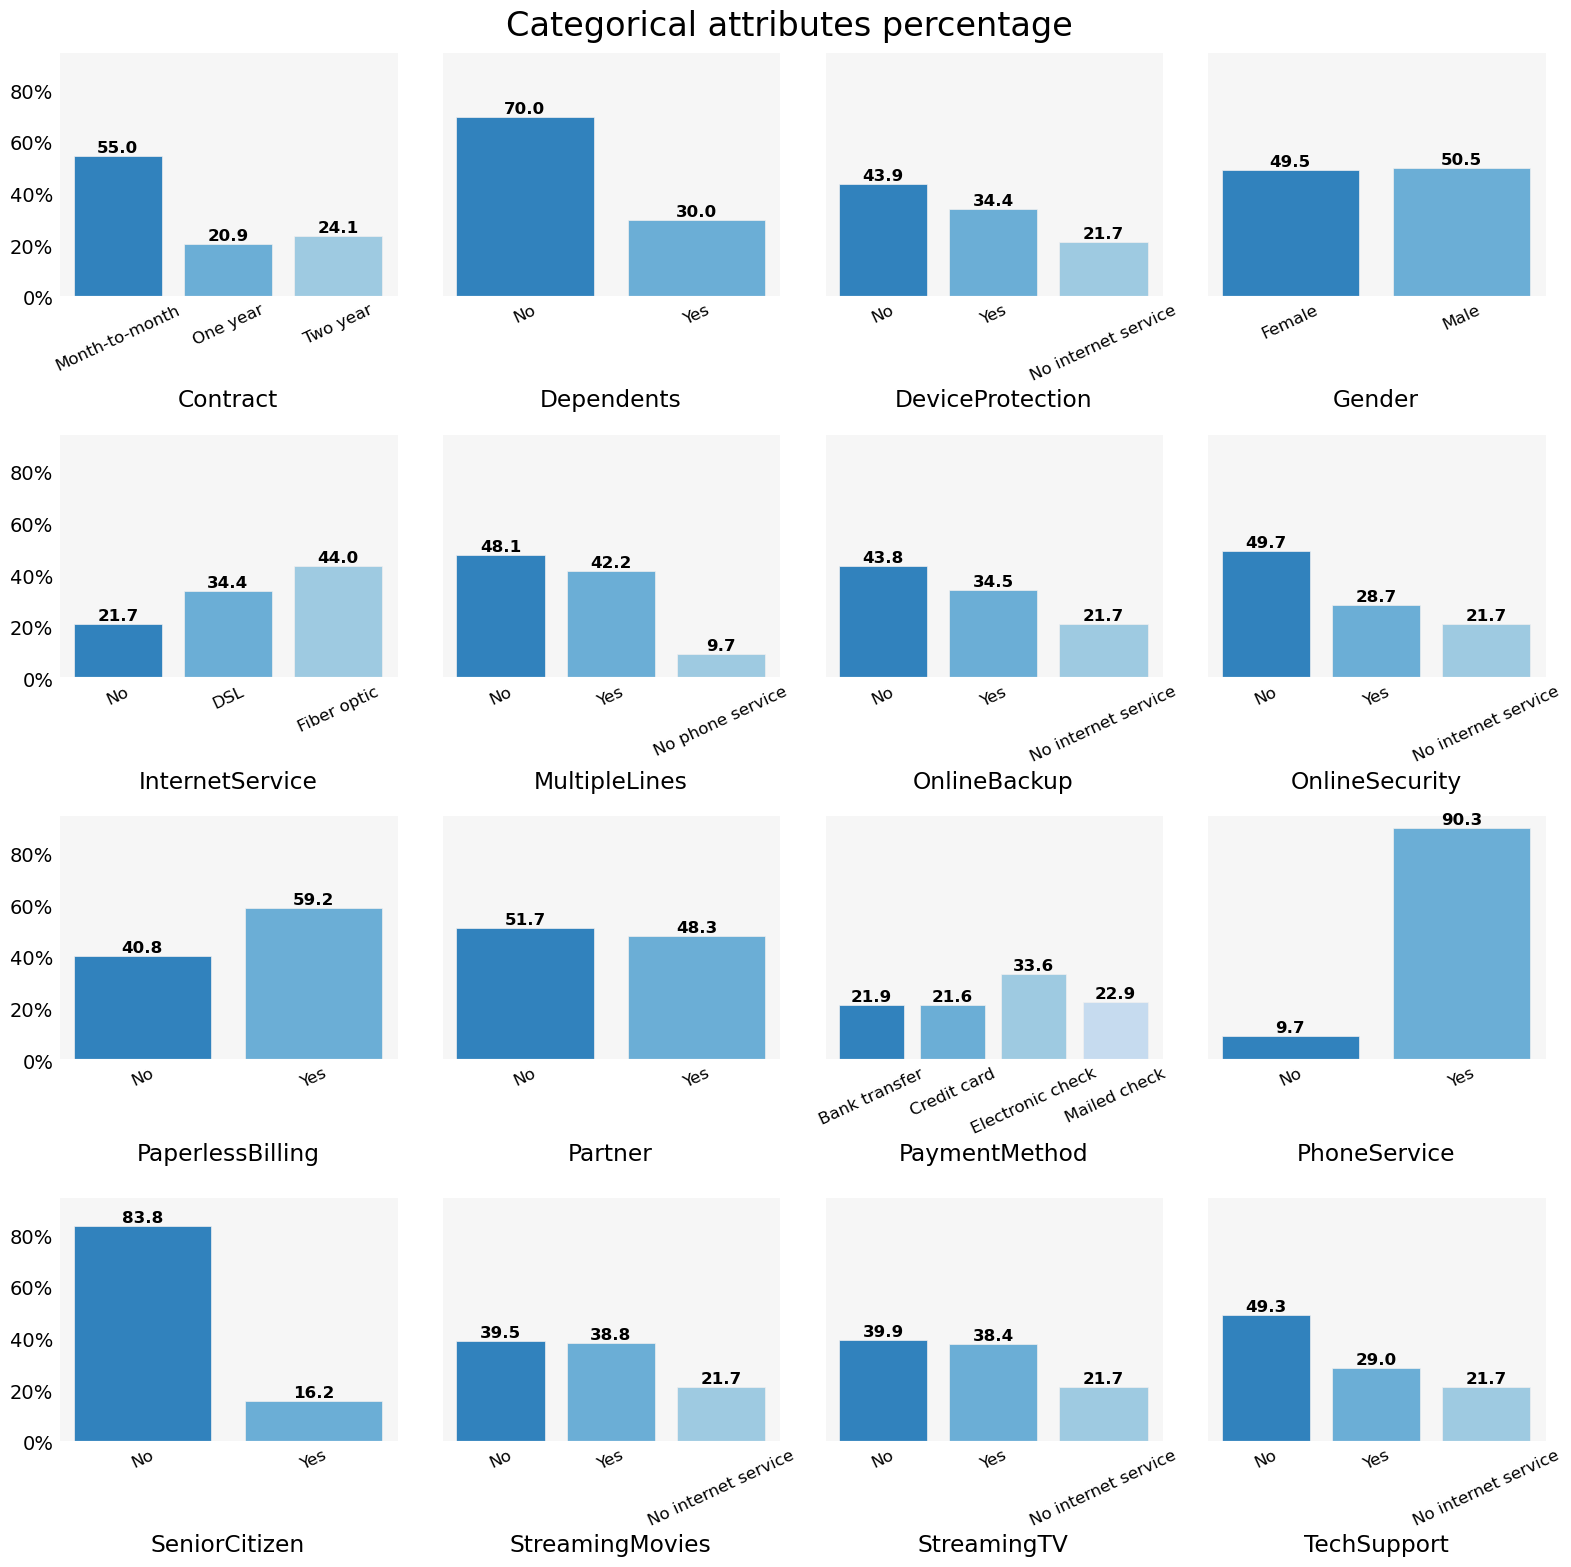

In [16]:
plot_categories_percentages(df, categorical_features)

Some highlights:

- the dataset is almost equally distributed in terms of gender
- 55.0 % of the customers have month-to-month contracts
- 21.7 % of the customers do not have internet service
- 90.3 % of the customers have phone service
- there are only 16.2 % senior customers. Thus, most customers are young people (less than 65 years)
- 48.3% have a partner, but only 30 % have dependents

We see that some categorical features have 'No' and 'No internet service' (or 'No phone
service') as categories. Maybe all of them can be labeled as 'No' if the categories
provide no additional information. We can check this, plotting the churn rate by
category:


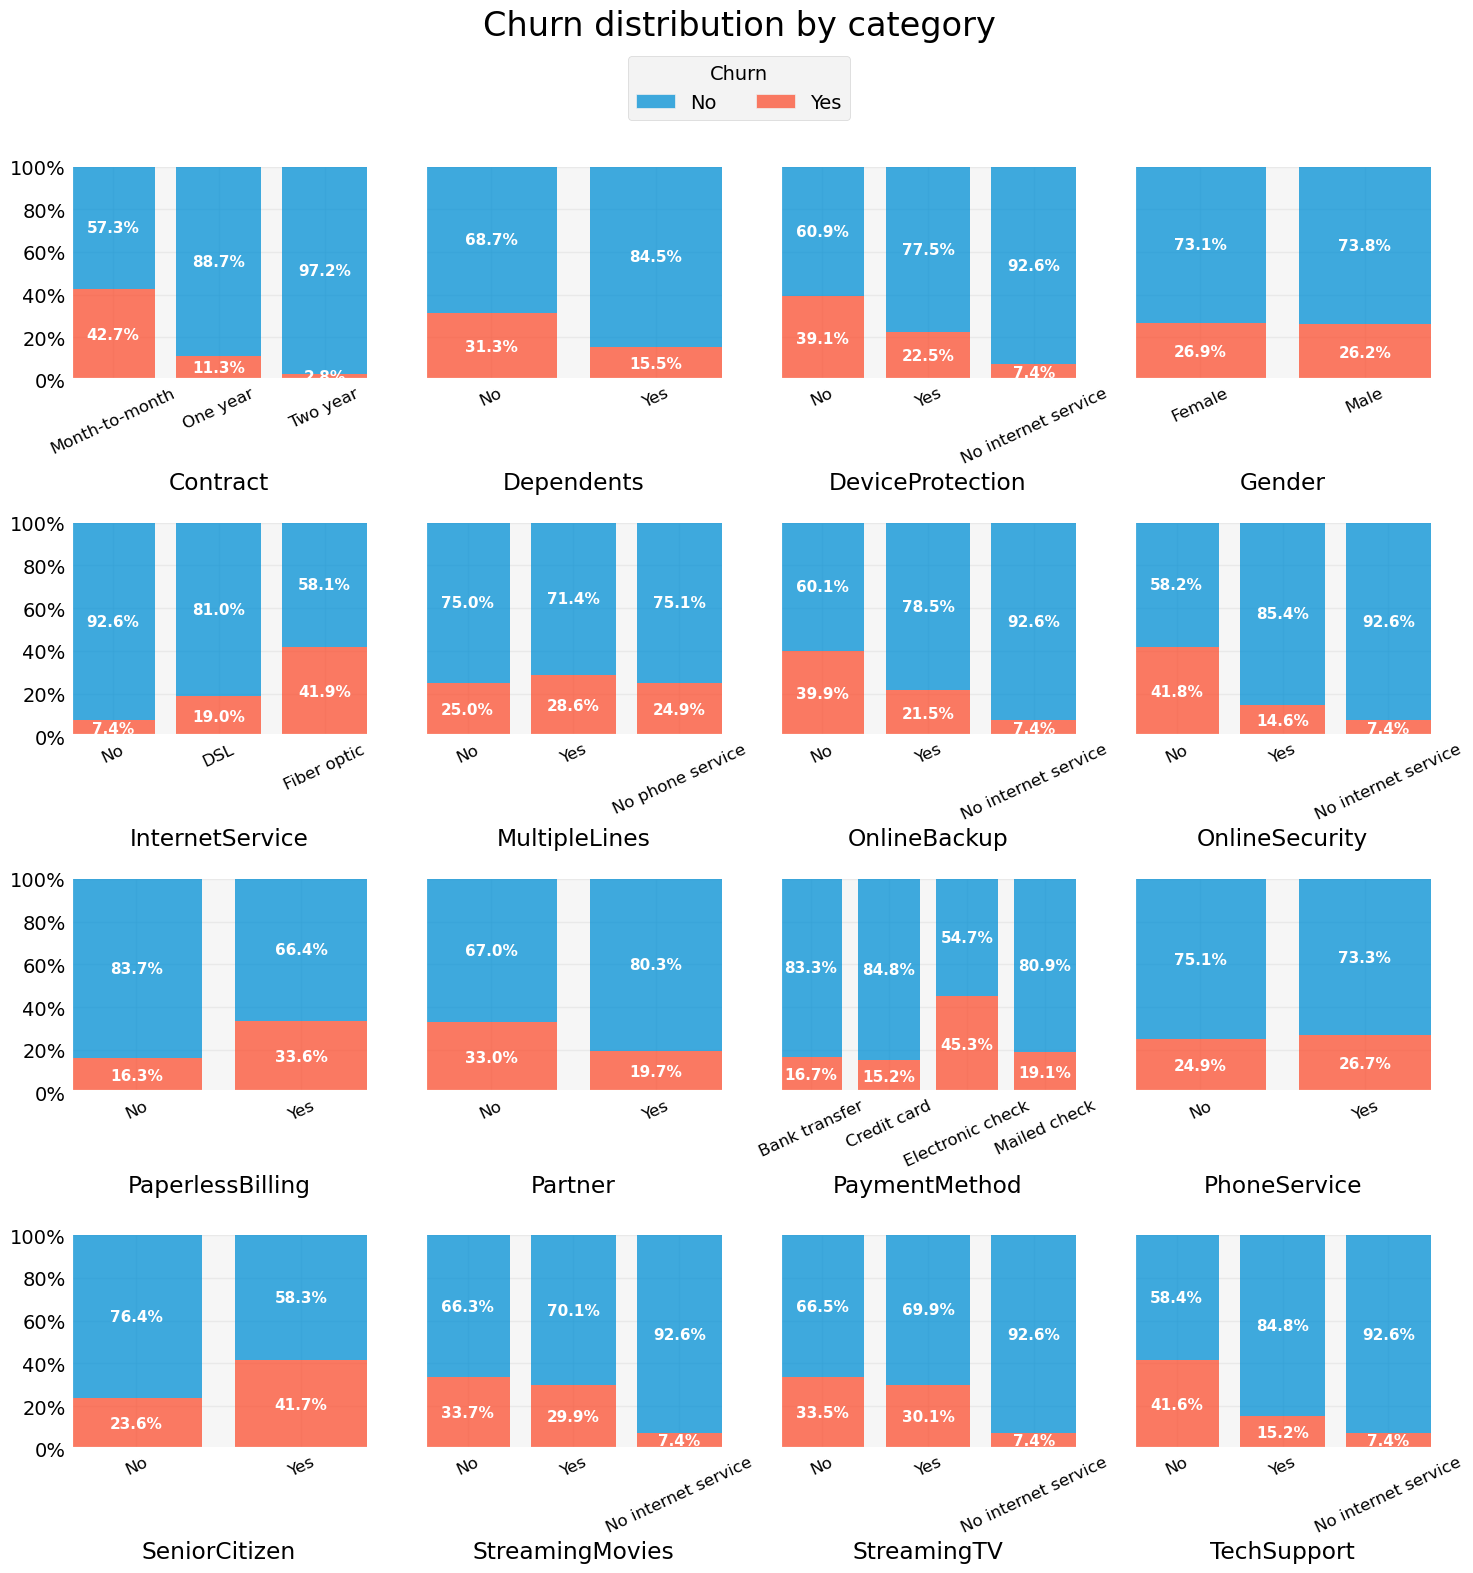

In [17]:
plot_target_distribution_by_category(
    df,
    categorical_features,
    column_target=target,
    figsize=(15, 15),
    legend_title="Churn",
    figure_title="Churn distribution by category",
)

Features that seem to be positively correlated with churn:

- month to month contracts
- absence of online backup, online security, and device protection services
- absence of tech support
- being a senior citizen
- paperless billing
- pay with electronic check
- internet service by fiber optic

Features that seem to be negatively correlated with churn:

- two-year contracts
- absence of internet service
- having a partner or dependent

We will quantify these correlations soon. First, let's try to interpret the findings.

Both genders behave similarly when it comes to migrating to another service provider.

It is interesting to see that each service that has the "No internet service" category
has much lower churn rates. Maybe the internet service provided by the company has
connectivity problems, particularly the fiber optic one. It could also be that the setup
is not easy, so that those who opted not to have tech support may not be able to use the
services. And that would be more severe in senior customers. While it appears that there
are issues with the fiber optic internet, the DSL one has a much lower churn rate
despite being a slower connection.

Since the "No internet service" category provided insights, it will not be merged with
the "No" category.

We can now invert the analysis and check the proportion of churned customers in each
category:

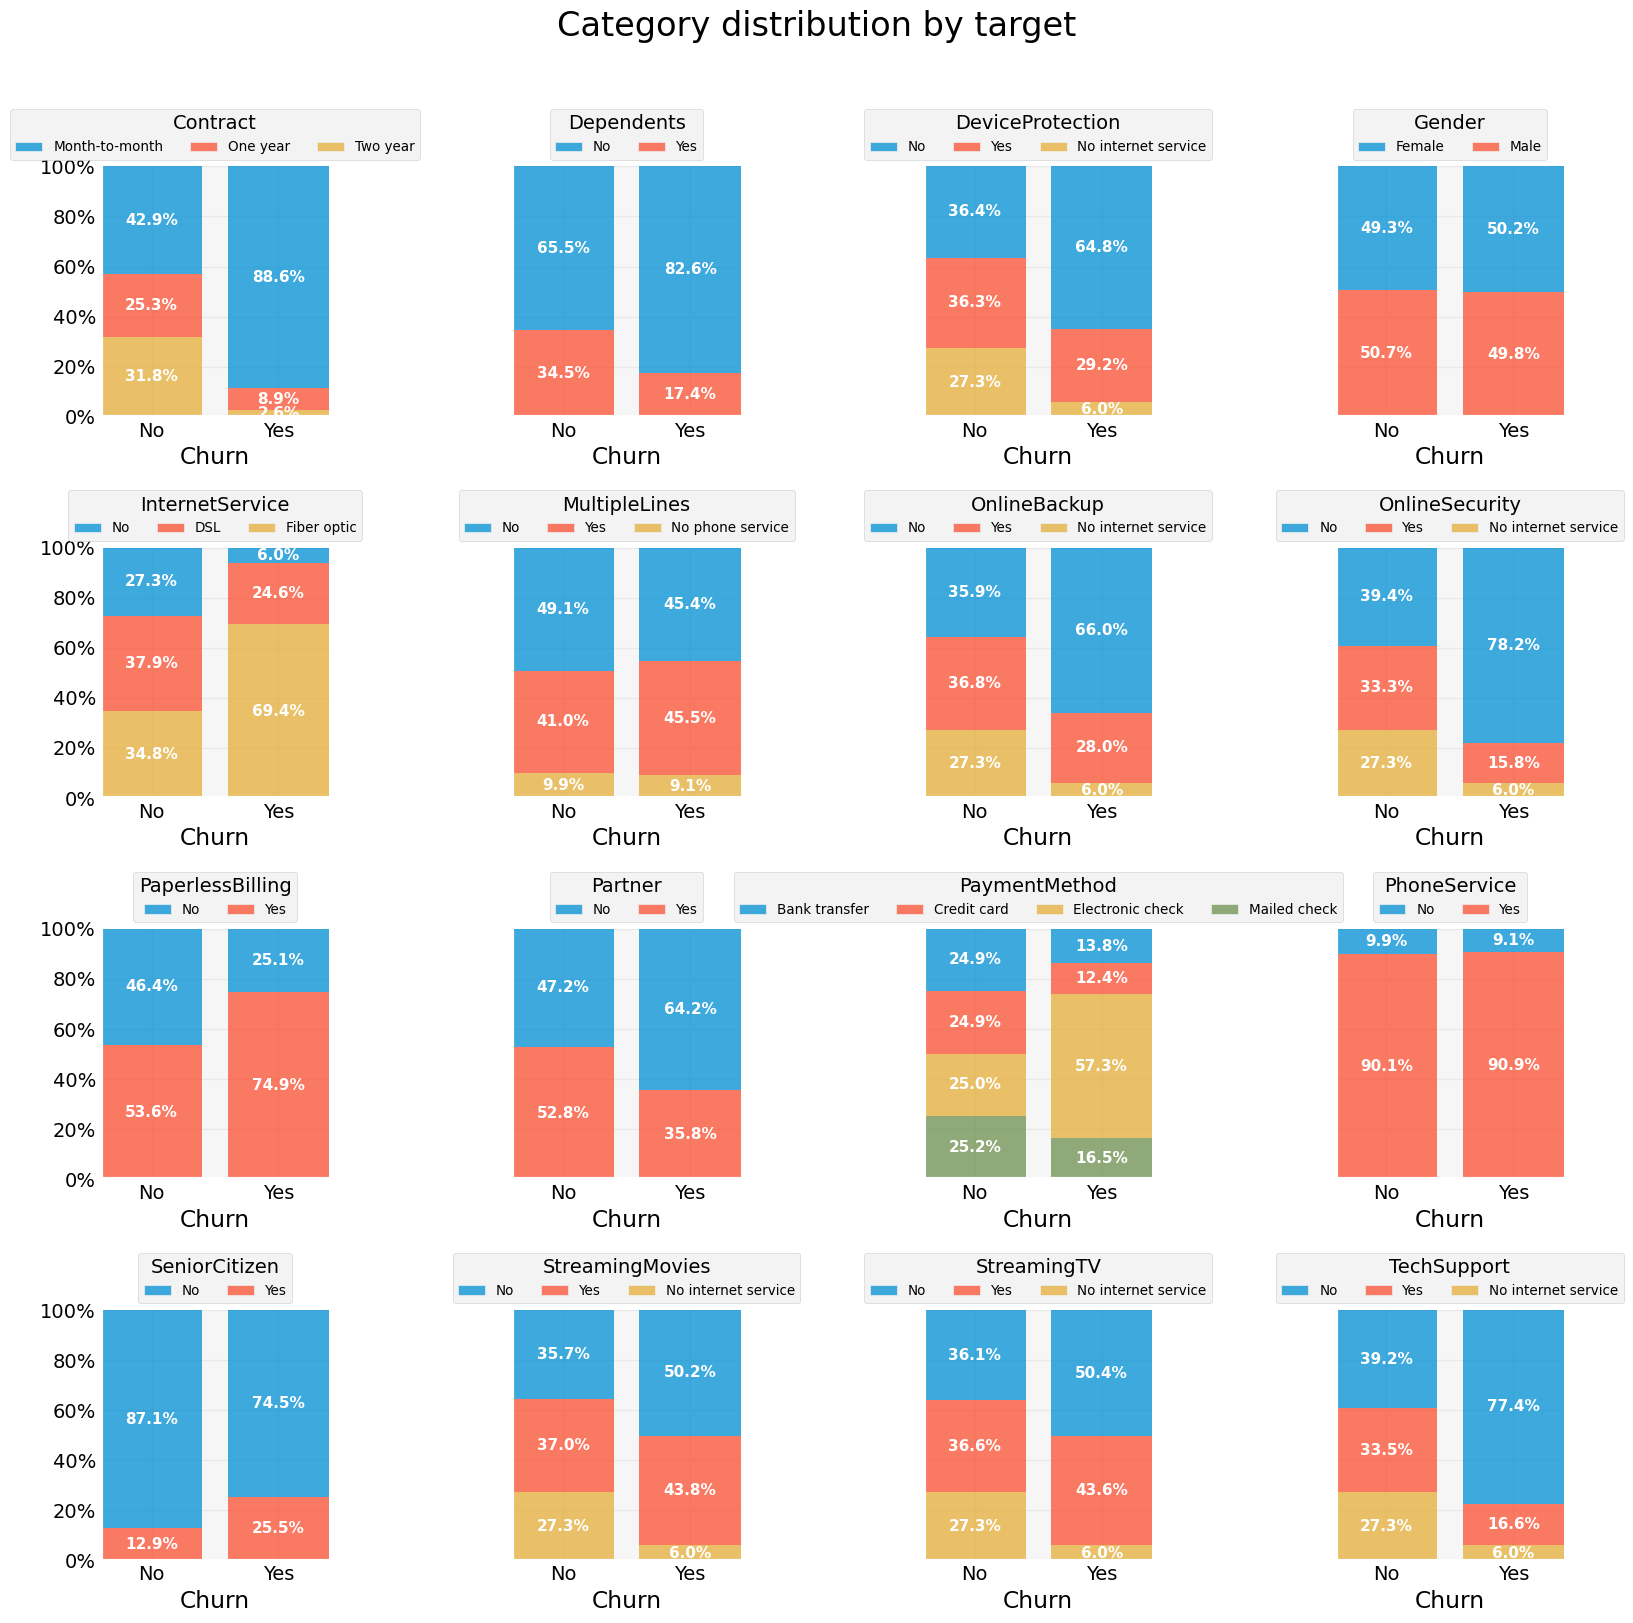

In [18]:
plot_category_distribution_by_target(
    df,
    categorical_features,
    column_target=target,
    figsize=(16, 16)
)

The data suggest that the more people at the customers' places, the less churn.
Customers with partners or dependents have lower churn rates. Probably because more
people are involved in the decision of leaving, making it more difficult.

For marketing reasons, we can see how many customers who have partners also have
dependents. Assuming that, in most cases, "dependents" mean children, it is more likely
that customers with partners will also have dependents. Let's check this assumption.

In [19]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total"
)

Dependents,No,Yes,Total
Partner,,,
No,3280,361,3641
Yes,1653,1749,3402
Total,4933,2110,7043


In [20]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total", normalize=True
)

Dependents,No,Yes,Total
Partner,,,
No,0.465711,0.051257,0.516967
Yes,0.234701,0.248332,0.483033
Total,0.700412,0.299588,1.000000


In [21]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total", normalize="index"
)

Dependents,No,Yes
Partner,,
No,0.900851,0.099149
Yes,0.485891,0.514109
Total,0.700412,0.299588


In [22]:
pd.crosstab(
    df["Partner"], df["Dependents"], margins=True, margins_name="Total", normalize="columns"
)

Dependents,No,Yes,Total
Partner,,,
No,0.66491,0.17109,0.516967
Yes,0.33509,0.82891,0.483033


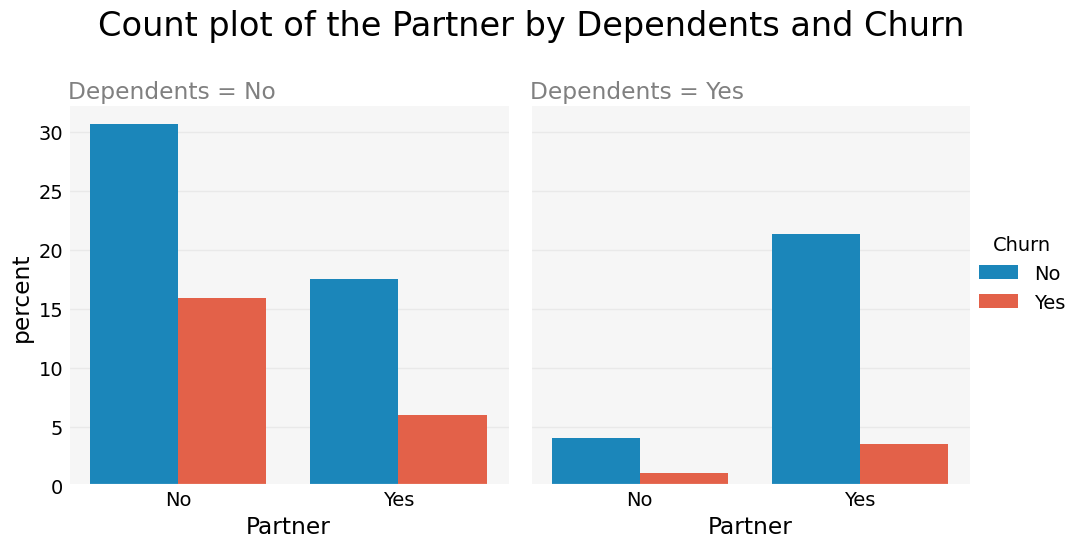

In [23]:
g = sns.catplot(
    data=df,
    x="Partner",
    col="Dependents",
    hue=target,
    kind="count",
    stat="percent",
)

g.figure.suptitle("Count plot of the Partner by Dependents and Churn", y=1.10)

plt.show()

Almost half of the customers with partners have dependents. Again, assuming that in most
cases "dependents" mean children, this means that marketing campaigns which aim at
avoiding churn may focus on single people.

## Statistical tests

The class `StatisticalAnalysisBinary` was especially created to perform statistical tests for binary classification problems:

In [24]:
stats = StatisticalAnalysisBinary(df, target, classes=("No", "Yes"))

Let's begin by checking the normality and the shape of the distributions of the numerical features:

In [25]:
stats.kolmolgorov_smirnov(columns=numeric_features)

,column,statistic,p_value,normal
0,MonthlyCharges,0.126195,3.151058e-98,False
1,Tenure,0.111016,4.662722e-76,False
2,TotalCharges,0.159268,1.568482e-156,False


In [26]:
stats.shape_analysis(columns=numeric_features)

,column,skewness,skewness_classification,kurtosis,kurtosis_classification
0,MonthlyCharges,-0.220524,left-skewed,-1.257260,platykurtic
1,Tenure,0.239540,right-skewed,-1.387372,platykurtic
2,TotalCharges,0.963316,right-skewed,-0.228487,platykurtic


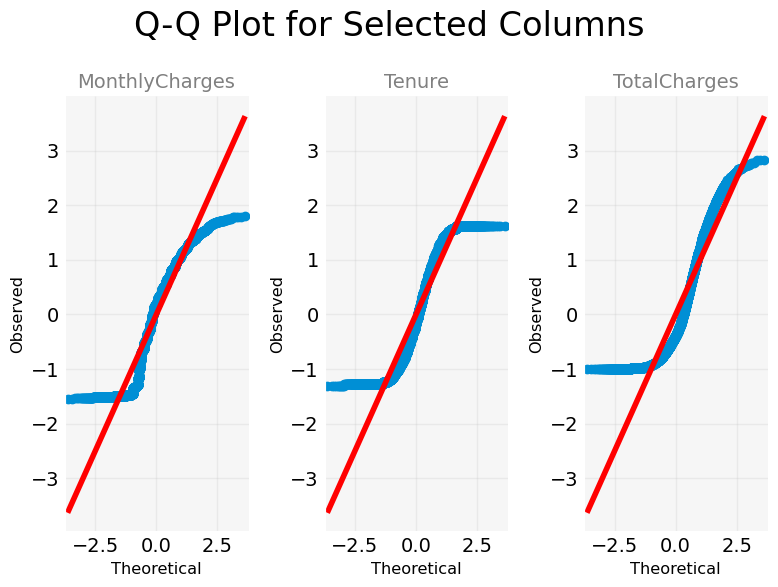

In [27]:
stats.plot_qqplot(columns=numeric_features, figsize=(8, 6))

None of the features have a normal distribution, and all of them have a skewed distribution. We can use the Mann-Whitney U test to check if the distributions of the features are significantly different for each class:

In [28]:
stats.mann_whitney(columns=numeric_features)

,column,statistic,p_value,different_distributions
0,MonthlyCharges,3667080.5,3.311628e-54,True
1,Tenure,7154668.0,2.419636e-208,True
2,TotalCharges,6290411.0,3.938012e-83,True


We see that all features have significantly different distributions for each class. This means that the features are good candidates for predicting the target variable. This is consistent with the EDA we have performed so far.

Concerning the categorical features, we can use the chi-square test to check if each category is significantly different for each class. Moreove, the Cramér's V statistic will be calculated to measure the strength of the association between the features and the target variable:

In [29]:
stats.association_chi2_cramer(columns=categorical_features)

,column,statistic,p_value,independent,less_than_5_any_cell,cramer_v
0,Contract,1184.596572,5.863038e-258,False,False,0.410116
1,Dependents,189.129249,4.924922e-43,False,False,0.163870
2,DeviceProtection,558.419369,5.505219e-122,False,False,0.281580
3,Gender,0.484083,4.865787e-01,True,False,0.008291
4,InternetService,732.309590,9.571788e-160,False,False,0.322455
5,MultipleLines,11.330441,3.464383e-03,False,False,0.040109
6,OnlineBackup,601.812790,2.079759e-131,False,False,0.292316
7,OnlineSecurity,849.998968,2.661150e-185,False,False,0.347400
8,PaperlessBilling,258.277649,4.073355e-58,False,False,0.191498
9,Partner,158.733382,2.139911e-36,False,False,0.150126


In [30]:
stats.association_chi2_cramer(columns=categorical_features).query("independent == True")

,column,statistic,p_value,independent,less_than_5_any_cell,cramer_v
3,Gender,0.484083,0.486579,True,False,0.008291
11,PhoneService,0.915033,0.338783,True,False,0.011398


In [31]:
stats.association_chi2_cramer(columns=categorical_features).query("cramer_v < 0.1")

,column,statistic,p_value,independent,less_than_5_any_cell,cramer_v
3,Gender,0.484083,0.486579,True,False,0.008291
5,MultipleLines,11.330441,0.003464,False,False,0.040109
11,PhoneService,0.915033,0.338783,True,False,0.011398


We see that the columns `Gender`, `PhoneService` and `MultipleLines` have a very low
association with the target variable. This means that these features are not good
candidates for predicting the target variable. This is consistent with the EDA we have
performed so far.
We can drop them from the dataset:

In [32]:
columns_to_drop = [
    "customerID",
    "Gender",
    "PhoneService",
    "MultipleLines",
]

Back to the numerical features, we can check if pairs of features are significantly
correlated. If two features are highly correlated, we can remove one of them to avoid
the same information being used twice in the model:

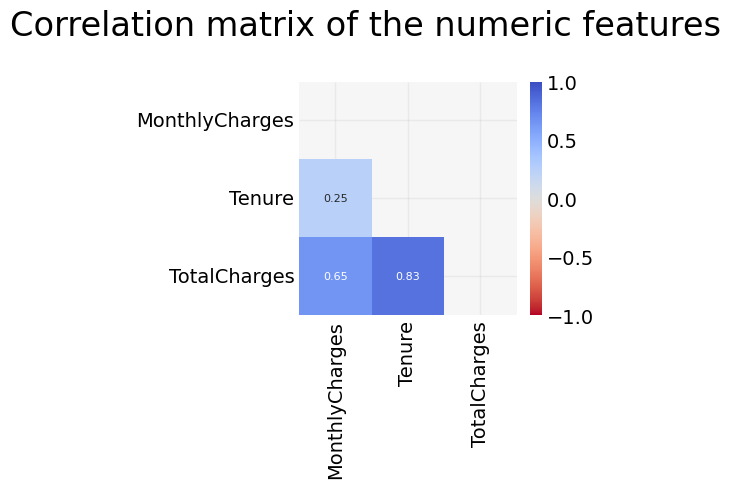

In [33]:
corr = df[numeric_features].corr()

fig, ax = plt.subplots(figsize=(5, 5))

h = sns.heatmap(
    corr,
    fmt=".2f",
    ax=ax,
    cmap="coolwarm_r",
    annot=True,
    annot_kws={"fontsize": 8},
    mask=np.triu(corr),
    vmax=1,
    vmin=-1,
)

# Rotate the tick labels for the y-axis
h.tick_params("y", labelrotation=0)

fig.suptitle("Correlation matrix of the numeric features")

plt.show()

We see a high correlation between `TotalCharges` and `Tenure`. This is expected, since
the longer the customer stays with the company, the higher this customer has paid. We can
check the VIF of the features to see if we can remove one of them.

The VIF is a measure of multicollinearity. It quantifies how much the variance of the
estimated regression coefficients are inflated due to multicollinearity in the model. A
VIF of 1 means that there is no correlation between the feature and the other features.
A VIF between 1 and 5 indicates moderate correlation, but it is not severe enough to
remove the feature. A VIF greater than 5 indicates severe correlation, and the feature
should be removed.

In [34]:
vif = pd.DataFrame()

vif["feature"] = numeric_features

vif["VIF"] = [
    variance_inflation_factor(df[numeric_features].values, i)
    for i in range(len(numeric_features))
]

vif

,feature,VIF
0,MonthlyCharges,3.355907
1,Tenure,6.332253
2,TotalCharges,8.075651


We see that the VIF of `TotalCharges` is very high. This means that the feature is
strongly correlated with the other features. We can remove it from the dataset.

In [35]:
columns_to_drop.append("TotalCharges")

Dropping the columns that have low association with the target variable and the
`TotalCharges` column, we have the final dataset:

In [36]:
df = df.drop(columns=columns_to_drop)

## Export the data

We can now export the data to be used in the next notebook.

In [37]:
df.to_parquet(PROCESSED_DATA_FILE, index=False, engine="fastparquet")